In [62]:
import os
from dotenv import load_dotenv
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine

In [63]:
load_dotenv(dotenv_path=".env")
db = os.getenv("db_url")
engine = create_engine(db)

In [64]:
nyc = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.nyc", con=engine)
la = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.la", con=engine)
chicago = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.chicago", con=engine)
bay = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.bay", con=engine)
dallas = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.dallas", con=engine)
dc = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.dc", con=engine)
houston = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.houston", con=engine)
boston = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.boston", con=engine)
atlanta = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.atlanta", con=engine)
seattle = pd.read_sql("SELECT ur20, area, isoperi, solidity, rectan, pop_den, geom FROM public.seattle", con=engine)

In [65]:
nyc['city'] = 'nyc'
la['city'] = 'la'
chicago['city'] = 'chicago'
bay['city'] = 'bay'
dallas['city'] = 'dallas'
dc['city'] = 'dc'
houston['city'] = 'houston'
boston['city'] = 'boston'
atlanta['city'] = 'atlanta'
seattle['city'] = 'seattle'

In [66]:
combined = pd.concat([nyc, la, chicago, bay, dallas, dc, houston, boston, atlanta, seattle]).reset_index(drop=True)
# combined = combined.loc[combined['city']=='nyc']
# combined

In [67]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from shapely import wkb, wkt
from shapely.geometry import Polygon, MultiPolygon,LinearRing

def parse_geom(g):
    return wkb.loads(bytes.fromhex(g))

def _turning_angle(p_prev, p, p_next):
    v1 = p_prev - p
    v2 = p_next - p
    n1 = np.linalg.norm(v1) + 1e-12
    n2 = np.linalg.norm(v2) + 1e-12
    cosang = np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)
    return np.arccos(cosang)

def polygon_to_graph(poly_hex: str, y_value=None):
    poly = wkb.loads(bytes.fromhex(poly_hex))

    if isinstance(poly, MultiPolygon):
        poly = max(poly.geoms, key=lambda p: p.area)

    ring = LinearRing(poly.exterior.coords)
    coords = np.array(ring.coords[:-1], dtype=np.float32)
    n = coords.shape[0]
    if n < 3:
        return None

    centroid = coords.mean(axis=0, keepdims=True)
    coords0 = coords - centroid

    prev_idx = (np.arange(n) - 1) % n
    next_idx = (np.arange(n) + 1) % n

    angles = np.array(
        [_turning_angle(coords0[prev_idx[i]], coords0[i], coords0[next_idx[i]]) for i in range(n)],
        dtype=np.float32
    )

    e_prev = np.linalg.norm(coords0 - coords0[prev_idx], axis=1).astype(np.float32)
    e_next = np.linalg.norm(coords0[next_idx] - coords0, axis=1).astype(np.float32)

    h_prev = 0.5 * e_prev
    h_next = 0.5 * e_next

    area = np.float32(poly.area)
    n_vertices = np.float32(n)

    area_col = np.full((n, 1), area, dtype=np.float32)
    ncol = np.full((n, 1), n_vertices, dtype=np.float32)

    x = np.concatenate(
        [coords0, angles[:, None], h_prev[:, None], h_next[:, None], area_col, ncol],
        axis=1
    )
    x = torch.from_numpy(x)

    src = torch.arange(n, dtype=torch.long)
    dst = torch.from_numpy(next_idx.astype(np.int64))
    edge_index = torch.stack([torch.cat([src, dst]), torch.cat([dst, src])], dim=0)

    data = Data(x=x, edge_index=edge_index)

    if y_value is not None:
        data.y = torch.tensor([float(y_value)], dtype=torch.float32)

    return data

In [68]:
combined["graph"] = combined["geom"].apply(polygon_to_graph)

In [69]:
combined['urbanity'] = (combined['ur20'] == 'U').astype(int)
combined

,ur20,area,isoperi,solidity,rectan,pop_den,geom,city,graph,urbanity
0,U,16200.825,0.697,1.000,0.956,28616.003,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-2.7466e-04, 9.6512e-04, 1.655...",1
1,U,24292.633,0.609,1.000,0.949,8742.396,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-1.5259e-05, 1.3580e-03, 1.714...",1
2,U,19628.887,0.663,1.000,0.964,10555.762,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-2.5940e-04, 1.1253e-03, 1.655...",1
3,U,15393.900,0.561,1.000,0.979,7739.343,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-1.2131e-03, 2.6321e-04, 1.515...",1
4,U,14438.490,0.654,1.000,0.903,80365.333,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-1.0147e-03, -4.5776e-04, 1.332...",1
...,...,...,...,...,...,...,...,...,...,...
746044,U,4523.137,0.570,0.992,0.911,37220.700,0106000020E61000000100000001030000000100000020...,seattle,"[(x, [tensor([-5.7983e-04, 8.7738e-05, 1.815...",1
746045,R,74509.144,0.545,0.808,0.606,1564.233,0106000020E6100000010000000103000000010000003A...,seattle,"[(x, [tensor([-1.9989e-03, -1.3390e-03, 1.195...",0
746046,U,275861.703,0.427,0.720,0.549,2243.902,0106000020E61000000100000001030000000100000060...,seattle,"[(x, [tensor([-3.3340e-03, -2.4490e-03, 3.122...",1
746047,U,93645.666,0.440,0.794,0.576,7826.994,0106000020E6100000010000000103000000010000002C...,seattle,"[(x, [tensor([-2.6779e-03, 9.9945e-04, 1.550...",1


In [70]:
combined['ur20'].value_counts()

ur20
U    721822
R     24227
Name: count, dtype: int64

In [71]:
combined['urbanity'].value_counts()

urbanity
1    721822
0     24227
Name: count, dtype: int64

In [75]:
combined["num_nodes"] = combined["graph"].apply(lambda g: g.num_nodes)
combined["num_nodes_norm"] = (combined["num_nodes"] - combined["num_nodes"].mean()) / combined["num_nodes"].std()
combined["area_norm"] = (combined["area"] - combined["area"].mean()) / combined["area"].std()

all_x = torch.cat([g.x for g in combined["graph"]], dim=0)
x_mean = all_x.mean(dim=0)
x_std = all_x.std(dim=0)
def normalize_graph(g):
    g = g.clone()
    g.x = (g.x - x_mean) / x_std
    return g

combined["graph_norm"] = combined["graph"].apply(normalize_graph)

In [76]:
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import torch

class GraphOnlyDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.target_col = "urbanity"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        g = row["graph_norm"].clone()
        y = torch.tensor([float(row[self.target_col])], dtype=torch.float32)

        area = torch.tensor([float(row["area_norm"])], dtype=torch.float32)
        num_nodes = torch.tensor([float(row["num_nodes_norm"])], dtype=torch.float32)

        g.y = y
        g.graph_feat = torch.cat([area, num_nodes], dim=0)
        return g

dataset = GraphOnlyDataset(combined)
loader = DataLoader(dataset, batch_size=512, shuffle=True)


In [77]:
print(dataset[1])  
print(dataset[1].x)
print(dataset[1].edge_index)
print(dataset[1].y)

Data(x=[4, 7], edge_index=[2, 8], y=[1], graph_feat=[2])
tensor([[-3.8756e-03,  4.3945e-01, -1.8766e+00,  4.0948e+00,  1.0685e+00,
         -2.3697e-01, -5.8034e-01],
        [ 2.4393e-01,  3.7279e-01, -2.3948e+00,  1.0685e+00,  4.0932e+00,
         -2.3697e-01, -5.8034e-01],
        [ 2.0245e-03, -4.3822e-01, -1.8671e+00,  4.0932e+00,  1.0538e+00,
         -2.3697e-01, -5.8034e-01],
        [-2.4381e-01, -3.7279e-01, -2.3931e+00,  1.0538e+00,  4.0948e+00,
         -2.3697e-01, -5.8034e-01]])
tensor([[0, 1, 2, 3, 1, 2, 3, 0],
        [1, 2, 3, 0, 0, 1, 2, 3]])
tensor([1.])


In [ ]:
nodes = []
edges = []
for i in range(1000):
    g = dataset[i]
    nodes.append(g.num_nodes)
    edges.append(g.edge_index.size(1))

print(min(nodes), max(nodes), sum(nodes)/len(nodes))
print(min(edges), max(edges), sum(edges)/len(edges))

3 1524 38.706
6 3048 77.412


# Graph Training Model

In [78]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool

class GraphClassifier(nn.Module):
    def __init__(self, node_in_dim: int, gnn_hidden: int = 64, use_feat: bool = True, feat_dim: int = 2):
        super().__init__()
        self.use_feat = use_feat
        self.feat_dim = feat_dim if use_feat else 0

        self.conv1 = GCNConv(node_in_dim, gnn_hidden)
        self.conv2 = GCNConv(gnn_hidden, gnn_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(gnn_hidden + self.feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, batch):
        x = self.conv1(batch.x, batch.edge_index)
        x = torch.relu(x)
        x = self.conv2(x, batch.edge_index)
        x = torch.relu(x)
        g = global_mean_pool(x, batch.batch)

        if self.use_feat:
            gf = batch.graph_feat
            if gf.dim() == 1:
                gf = gf.view(g.size(0), -1)
            z = torch.cat([g, gf], dim=1)
        else:
            z = g

        return self.mlp(z)

device = torch.device("cuda")
node_in_dim = dataset[0].x.size(1)

def run(use_feat):
    model = GraphClassifier(node_in_dim=node_in_dim, use_feat=use_feat, feat_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_urban = (combined["urbanity"] == 1).sum()
    num_rural = (combined["urbanity"] == 0).sum()

    pos_weight = torch.tensor([num_urban / num_rural], device=device)  # rural=1, urban=0
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    model.train()
    for epoch in range(5):
        total_loss = 0.0
        correct = 0
        total = 0

        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)

            yb = (batch.y.view(-1, 1) == 0).float()  # rural=1, urban=0

            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * yb.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        avg_loss = total_loss / total
        error_rate = 1.0 - (correct / total)
        print(f"use_feat={use_feat} | Epoch {epoch+1}: loss = {avg_loss:.4f}, error_rate = {error_rate:.4f}")

    model.eval()
    eval_loader = DataLoader(dataset, batch_size=512, shuffle=False)

    y_pred = []
    with torch.no_grad():
        for batch in eval_loader:
            batch = batch.to(device)
            logits = model(batch)
            preds_rural = (torch.sigmoid(logits) >= 0.5).int()  # 1=rural, 0=urban
            preds_urban = (1 - preds_rural).view(-1)
            y_pred.extend(preds_urban.cpu().tolist())

    combined['y_pred'] = y_pred


# run(use_feat=False)
run(use_feat=True)

use_feat=True | Epoch 1: loss = 0.8941, error_rate = 0.1722
use_feat=True | Epoch 2: loss = 0.8513, error_rate = 0.1721
use_feat=True | Epoch 3: loss = 0.8254, error_rate = 0.1665
use_feat=True | Epoch 4: loss = 0.8106, error_rate = 0.1603
use_feat=True | Epoch 5: loss = 0.7980, error_rate = 0.1552


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(combined['urbanity'], combined['y_pred'])

array([[   842,    167],
       [ 17720, 103786]], dtype=int64)

# Evaluation for nn tuning

In [ ]:
model.eval()
pred_loader = DataLoader(dataset, batch_size=2048, shuffle=False, num_workers=0, pin_memory=True)

all_pred = []
with torch.inference_mode():
    for batch in pred_loader:
        batch = batch.to(device)
        pred = model(batch).view(-1).detach().cpu().numpy()
        all_pred.append(pred)

combined["y_pred"] = np.concatenate(all_pred)

C:\Users\kdgki\AppData\Local\Temp\ipykernel_42892\876383157.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["y_pred"] = np.concatenate(all_pred)


In [ ]:
combined

,ur20,area,isoperi,solidity,rectan,pop_den,geom,city,graph,y_pred
0,U,16200.825,0.697,1.000,0.956,28616.003,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-2.7466e-04, 9.6512e-04, 1.655...",22699.458984
1,U,24292.633,0.609,1.000,0.949,8742.396,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-1.5259e-05, 1.3580e-03, 1.714...",22704.707031
2,U,19628.887,0.663,1.000,0.964,10555.762,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-2.5940e-04, 1.1253e-03, 1.655...",22701.607422
3,U,15393.900,0.561,1.000,0.979,7739.343,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-1.2131e-03, 2.6321e-04, 1.515...",22700.947266
4,U,14438.490,0.654,1.000,0.903,80365.333,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-1.0147e-03, -4.5776e-04, 1.332...",22698.958984
...,...,...,...,...,...,...,...,...,...,...
122510,U,1207.169,0.099,0.987,0.917,0.000,0106000020E6100000010000000103000000010000000A...,nyc,"[(x, [tensor([-1.0452e-03, -1.1063e-04, 1.916...",23968.439453
122511,U,26240.455,0.478,0.983,0.804,6415.748,0106000020E61000000100000001030000000100000007...,nyc,"[(x, [tensor([-1.6785e-03, 7.2479e-05, 3.111...",24627.435547
122512,U,26385.473,0.645,0.972,0.890,8638.202,0106000020E6100000010000000103000000010000000D...,nyc,"[(x, [tensor([-7.0953e-04, -7.2479e-05, 2.899...",19483.277344
122513,U,12150.579,0.616,1.000,0.979,9378.609,0106000020E61000000100000001030000000100000005...,nyc,"[(x, [tensor([-9.7656e-04, 2.7466e-04, 1.520...",22698.115234


In [ ]:
import numpy as np

y_true = combined["pop_den"].to_numpy(dtype=float)
y_pred = combined["y_pred"].to_numpy(dtype=float)

ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true - y_true.mean()) ** 2)

r2 = 1.0 - ss_res / (ss_tot + 1e-12)

print("R2:", r2)

R2: 0.06559805661766183


Text(0.5, 1.0, 'population density')

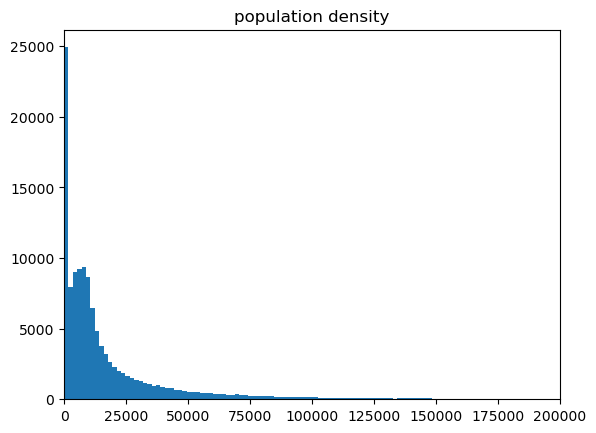

In [ ]:
import matplotlib.pyplot as plt

plt.hist(combined['pop_den'], bins=1000)
plt.xlim(0,200000)
plt.title('population density')
# plt.xscale('log')

Text(0.5, 1.0, 'population density y_pred')

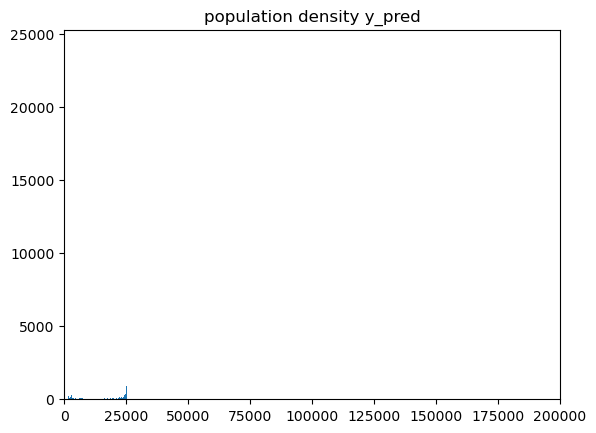

In [ ]:
import matplotlib.pyplot as plt

plt.hist(combined['y_pred'], bins=1000)
plt.xlim(0,200000)
plt.title('population density y_pred')
# plt.xscale('log')

In [ ]:
print(combined.pop_den.min())
print(combined.pop_den.max())
print(combined.pop_den.median())
print(combined.pop_den.mean())

0.0
1766207.405
8983.614
19368.821903244505


In [ ]:
print(combined.y_pred.min())
print(combined.y_pred.max())
print(combined.y_pred.median())
print(combined.y_pred.mean())

1643.1482
25285.967
22694.932
18114.053
